## Packages, parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import pickle
from tqdm import tqdm
from utils.visualize import show_loss
from utils.data import collate_EP

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# hyperparameters
BATCH_SIZE = 256
EPOCH = 1
LEARNING_RATE = 2e-5
MAX_FRAME = 200
DIM_TOKEN = 45
DROPOUT_PROB = 1e-1

# dictionary for classification
dict_class = {
    'action': ['bodylower', 'bodyscratch', 'bodyshake',
               'feetup', 'footup', 'heading', 'lying',
               'mounting', 'sit', 'tailing', 'taillow',
               'turn', 'walkrun'],
    'emotion': ['aggresive', 'feared', 'anxiety',
                'relaxed', 'excited', 'offended'],
}
num_action = len(dict_class['action'])
num_emotion = len(dict_class['emotion'])

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

Device: cuda


## **Dataloader**

In [4]:
class KeyDataset(Dataset):
    def __init__(self, label):
        self.label = pd.read_csv(label)
        self.seq = self.label['seq'].unique()

    def __len__(self):
        return self.seq.size
    
    def to_tensor(self, series):
        return torch.tensor(series.apply(ast.literal_eval).values.tolist(), dtype=float)
    
    def norm_keys(self, bbox, keys):
        for i in range(bbox.shape[0]):
            w = bbox[i][2] - bbox[i][0]
            h = bbox[i][3] - bbox[i][1]
            
            keys[i, :, 0] = (keys[i, :, 0] - bbox[i][0]) / w
            keys[i, :, 1] = (keys[i, :, 1] - bbox[i][1]) / h
            
            for j in range(15):
                if keys[i, j, -1] == 0:
                    keys[i, j] = torch.tensor([0, 0, 0], dtype=float)
        return keys

    def __getitem__(self, idx):
        s = self.seq[idx]
        target = self.label[self.label['seq']==s]
        
        bbox = self.to_tensor(target['bbox'])
        keys = self.to_tensor(target['keypoints'])
        keys = self.norm_keys(bbox, keys)
        
        action, emotion = target[['action', 'emotion']].iloc[0]
        action = F.one_hot(torch.tensor([action]), num_action)
        emotion = F.one_hot(torch.tensor([emotion]), num_emotion)
        
        return keys, action, emotion

In [5]:
# dataset for training
train_dataset = KeyDataset(
    'data/train/label.csv',
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_EP,
    shuffle=True,
)

In [6]:
train_keys = next(iter(train_dataloader))

In [7]:
print(train_keys.keys())
print(train_keys['keys'].shape)
print(train_keys['action'].shape)
print(train_keys['emotion'].shape)

dict_keys(['keys', 'action', 'emotion'])
torch.Size([256, 14, 15, 3])
torch.Size([256, 13])
torch.Size([256, 6])


## **Emotion Prediction**
    - Input: ...
    - Output: ...

In [8]:
from torch.nn import TransformerEncoder as trEnc
from torch.nn import TransformerEncoderLayer as trEncLayer

In [9]:
class EPencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # layers
        self.encoder_layer = trEncLayer(d_model=DIM_TOKEN,
                                        nhead=15,
                                        activation='gelu',
                                        batch_first=True,
                                        norm_first=True)
        self.encoder = trEnc(encoder_layer=self.encoder_layer, 
                             num_layers=6)
        self.mlp_action = self.get_MLP(num_action)
        self.mlp_emotion = self.get_MLP(num_emotion)
        self.dropout = nn.Dropout(DROPOUT_PROB)
        
        # tokens
        self.pos_embedding = nn.Parameter(torch.randn(1, MAX_FRAME + 2, DIM_TOKEN))
        self.action_token = nn.Parameter(torch.randn(1, 1, DIM_TOKEN))
        self.emotion_token = nn.Parameter(torch.randn(1, 1, DIM_TOKEN))
        
    def get_MLP(self, len_cls):
        return nn.Sequential(nn.LayerNorm(DIM_TOKEN),
                             nn.Linear(DIM_TOKEN, len_cls),
                             nn.Softmax(1))

    def forward(self, x):     
        # [B, N, 45]
        B, N, _ = x.shape
        
        act_token = self.action_token.repeat(B, 1, 1)
        emo_token = self.emotion_token.repeat(B, 1, 1)
        x = torch.cat((act_token, emo_token, x), dim=1)
        
        x += self.pos_embedding[:, :(N + 2)]
        x = self.dropout(x)
        
        x = self.encoder(x)
        
        act_output = x[:, 0]
        emo_output = x[:, 1]
        
        return self.mlp_action(act_output), self.mlp_emotion(emo_output)

In [10]:
model_EP = EPencoder()
model_EP = model_EP.double().to(device)

### Training

In [11]:
model_EP = model_EP.train()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model_EP.parameters(), lr=LEARNING_RATE)
loss_train = []

In [517]:
for e in range(EPOCH):
    for data in tqdm(train_dataloader):
        optimizer.zero_grad()
        
        out_act, out_emo = model_EP(torch.flatten(data['keys'], 2).to(device))
        loss_act = criterion(out_act, data['action'].float().to(device))
        loss_emo = criterion(out_emo, data['emotion'].float().to(device))
        
        loss = loss_act + loss_emo
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 155/155 [03:54<00:00,  1.51s/it]


In [518]:
loss_train = [x.cpu().detach() for x in loss_train]

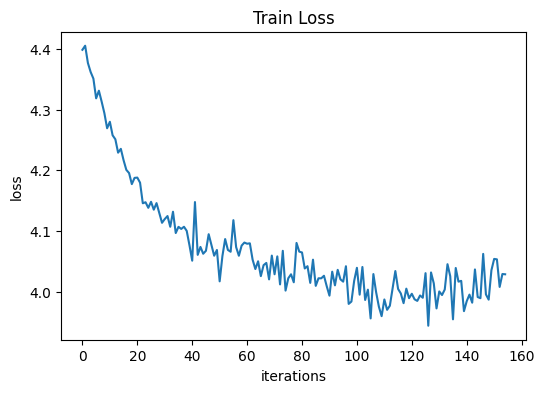

In [16]:
show_loss(loss_train)

In [525]:
# saving model state
torch.save(model_EP.state_dict(), 'state/model_EP_B256_E1_L2e-5')

In [526]:
# saving loss values
with open('state/loss_EP_B256_E1_L2e-5.pkl','wb') as f:
    pickle.dump(loss_train, f)

### Test

In [17]:
model_EP = model_EP.eval()
p = model_EP(torch.flatten(train_keys['keys'], 2).to(device))

In [18]:
p[1][0]

tensor([0.0031, 0.0114, 0.0163, 0.9032, 0.0580, 0.0080], device='cuda:0',
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [19]:
train_keys['emotion'][0]

tensor([0, 0, 0, 1, 0, 0])

### Loading

In [13]:
# loading previous model state
model_EP.load_state_dict(torch.load('state/model_EP_B256_E1_L2e-5'))

<All keys matched successfully>

In [15]:
# loading previous loss values
with open('state/loss_EP_B256_E1_L2e-5.pkl','rb') as f:
    loss_train = pickle.load(f)

# Memo

Positional Embedding 문제  
Training set은 17 정도가 끝인데  
Val set은 0 ~ 178까지 다양하다  
learnable한 embedding을 사용한다면 17 이후의 embedding은 학습되지 않을 것이다.  